In [ ]:
# Import libraries
import pandas as pd
import numpy as np
from sklearn.impute import KNNImputer
from sklearn.preprocessing import RobustScaler
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split

In [ ]:
# Import data file from GItHub
url = 'https://raw.githubusercontent.com/khoocheeshin/HIA303BreastCancerProject/refs/heads/main/Selected-data-and-description-files/breast-cancer-wisconsin.data'

# Load the data file into a DataFrame
bcw = pd.read_csv(url, header=None)

## **DATA STRUCTURING**

In [ ]:
# Rename columns
column_names = [
    'ID', 'clump_thickness', 'uniformity_cell_size', 'uniformity_cell_shape',
    'marginal_adhesion', 'single_epithelial_cell_size', 'bare_nuclei',
    'bland_chromatin', 'normal_nucleoli', 'mitoses', 'diagnosis'
]
bcw.columns = column_names

# Display the first 20 rows to confirm it's loaded correctly
bcw.head(20)

,ID,clump_thickness,uniformity_cell_size,uniformity_cell_shape,marginal_adhesion,single_epithelial_cell_size,bare_nuclei,bland_chromatin,normal_nucleoli,mitoses,diagnosis
0,1000025,5,1,1,1,2,1,3,1,1,2
1,1002945,5,4,4,5,7,10,3,2,1,2
2,1015425,3,1,1,1,2,2,3,1,1,2
3,1016277,6,8,8,1,3,4,3,7,1,2
4,1017023,4,1,1,3,2,1,3,1,1,2
5,1017122,8,10,10,8,7,10,9,7,1,4
6,1018099,1,1,1,1,2,10,3,1,1,2
7,1018561,2,1,2,1,2,1,3,1,1,2
8,1033078,2,1,1,1,2,1,1,1,5,2
9,1033078,4,2,1,1,2,1,2,1,1,2


In [ ]:
# Overview of DataFrame: range of rows, number of columns, column names, non null counts and data types
bcw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 699 entries, 0 to 698
Data columns (total 11 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   ID                           699 non-null    int64 
 1   clump_thickness              699 non-null    int64 
 2   uniformity_cell_size         699 non-null    int64 
 3   uniformity_cell_shape        699 non-null    int64 
 4   marginal_adhesion            699 non-null    int64 
 5   single_epithelial_cell_size  699 non-null    int64 
 6   bare_nuclei                  699 non-null    object
 7   bland_chromatin              699 non-null    int64 
 8   normal_nucleoli              699 non-null    int64 
 9   mitoses                      699 non-null    int64 
 10  diagnosis                    699 non-null    int64 
dtypes: int64(10), object(1)
memory usage: 60.2+ KB


## **DATA CLEANING**

In [ ]:
# 1. Check for duplicate rows
duplicates = bcw[bcw.duplicated()]

# Print information about duplicates
if duplicates.empty:
    print("No duplicate rows found in the dataset.")
else:
    print(f"Found {len(duplicates)} duplicate rows in the dataset.")
    print("Duplicate rows:")
    print(duplicates)

# Remove duplicate rows
bcw_cleaned = bcw.drop_duplicates()

# Verify the duplicates are removed
print(f"\nDataset after removing duplicates has {bcw_cleaned.shape[0]} rows.")

Found 8 duplicate rows in the dataset.
Duplicate rows:
          ID  clump_thickness  uniformity_cell_size  uniformity_cell_shape  \
208  1218860                1                     1                      1   
253  1100524                6                    10                     10   
254  1116116                9                    10                     10   
258  1198641                3                     1                      1   
272   320675                3                     3                      5   
338   704097                1                     1                      1   
561  1321942                5                     1                      1   
684   466906                1                     1                      1   

     marginal_adhesion  single_epithelial_cell_size bare_nuclei  \
208                  1                            1           1   
253                  2                            8          10   
254                  1                   

In [ ]:
# 2. Check for missing values
# Replace the missing values (i.e. with “?”) with a NaN (Not a Number) value
bcw_cleaned = bcw_cleaned.replace('?', np.nan)

# Count the total number of NaN values in each column
nan_counts = bcw_cleaned.isnull().sum()
# Display the total NaN counts in each column
print("Total NaN counts in each column:\n", nan_counts)

Total NaN counts in each column:
 ID                              0
clump_thickness                 0
uniformity_cell_size            0
uniformity_cell_shape           0
marginal_adhesion               0
single_epithelial_cell_size     0
bare_nuclei                    16
bland_chromatin                 0
normal_nucleoli                 0
mitoses                         0
diagnosis                       0
dtype: int64


In [ ]:
# Convert all columns to numeric type (float) to use KNN imputer
bcw_cleaned = bcw_cleaned.apply(pd.to_numeric, errors='coerce')

# Initialize the KNN imputer with 2 nearest neighbors
imputer = KNNImputer(n_neighbors=2)

# Impute missing values
bcw_imputed = pd.DataFrame(imputer.fit_transform(bcw_cleaned), columns=bcw_cleaned.columns)

# Round all values to integers and convert to int type
bcw_imputed = bcw_imputed.round().astype(int)

# Verify that there are no more missing values
nan_counts_after_imputation = bcw_imputed.isnull().sum()
print("Total NaN counts in each column after kNN imputation:\n", nan_counts_after_imputation)

Total NaN counts in each column after kNN imputation:
 ID                             0
clump_thickness                0
uniformity_cell_size           0
uniformity_cell_shape          0
marginal_adhesion              0
single_epithelial_cell_size    0
bare_nuclei                    0
bland_chromatin                0
normal_nucleoli                0
mitoses                        0
diagnosis                      0
dtype: int64


In [ ]:
# 3. Check for data consistency in the target column (2 = benign and 4 = malignant)
# and feature columns (integer 1 to 10)
for column in bcw_imputed.columns:
    if column != 'ID':
        unique_values = bcw_imputed[column].unique()
        print(f"Unique values in {column}: {unique_values}")

Unique values in clump_thickness: [ 5  3  6  4  8  1  2  7 10  9]
Unique values in uniformity_cell_size: [ 1  4  8 10  2  3  7  5  6  9]
Unique values in uniformity_cell_shape: [ 1  4  8 10  2  3  5  6  7  9]
Unique values in marginal_adhesion: [ 1  5  3  8 10  4  6  2  9  7]
Unique values in single_epithelial_cell_size: [ 2  7  3  1  6  4  5  8 10  9]
Unique values in bare_nuclei: [ 1 10  2  4  3  9  7  5  8  6]
Unique values in bland_chromatin: [ 3  9  1  2  4  5  7  8  6 10]
Unique values in normal_nucleoli: [ 1  2  7  4  5  3 10  6  9  8]
Unique values in mitoses: [ 1  5  4  2  3  7 10  8  6]
Unique values in diagnosis: [2 4]


## **DESCRIPTIVE ANALYSIS**

In [ ]:
# Drop the ID column
df = bcw_cleaned.drop(columns=['ID'])

# Summary statistics for features
print('Summary of Statistics:\n', df.drop(columns=['diagnosis']).describe())

# Distribution of diagnosis
print('\nDistribution of diagnosis:\n', df['diagnosis'].value_counts())

Summary of Statistics:
        clump_thickness  uniformity_cell_size  uniformity_cell_shape  \
count       691.000000            691.000000             691.000000   
mean          4.426918              3.130246               3.201158   
std           2.815861              3.041328               2.959886   
min           1.000000              1.000000               1.000000   
25%           2.000000              1.000000               1.000000   
50%           4.000000              1.000000               1.000000   
75%           6.000000              5.000000               5.000000   
max          10.000000             10.000000              10.000000   

       marginal_adhesion  single_epithelial_cell_size  bare_nuclei  \
count         691.000000                   691.000000   675.000000   
mean            2.824891                     3.211288     3.537778   
std             2.866552                     2.199852     3.637871   
min             1.000000                     1.000000   

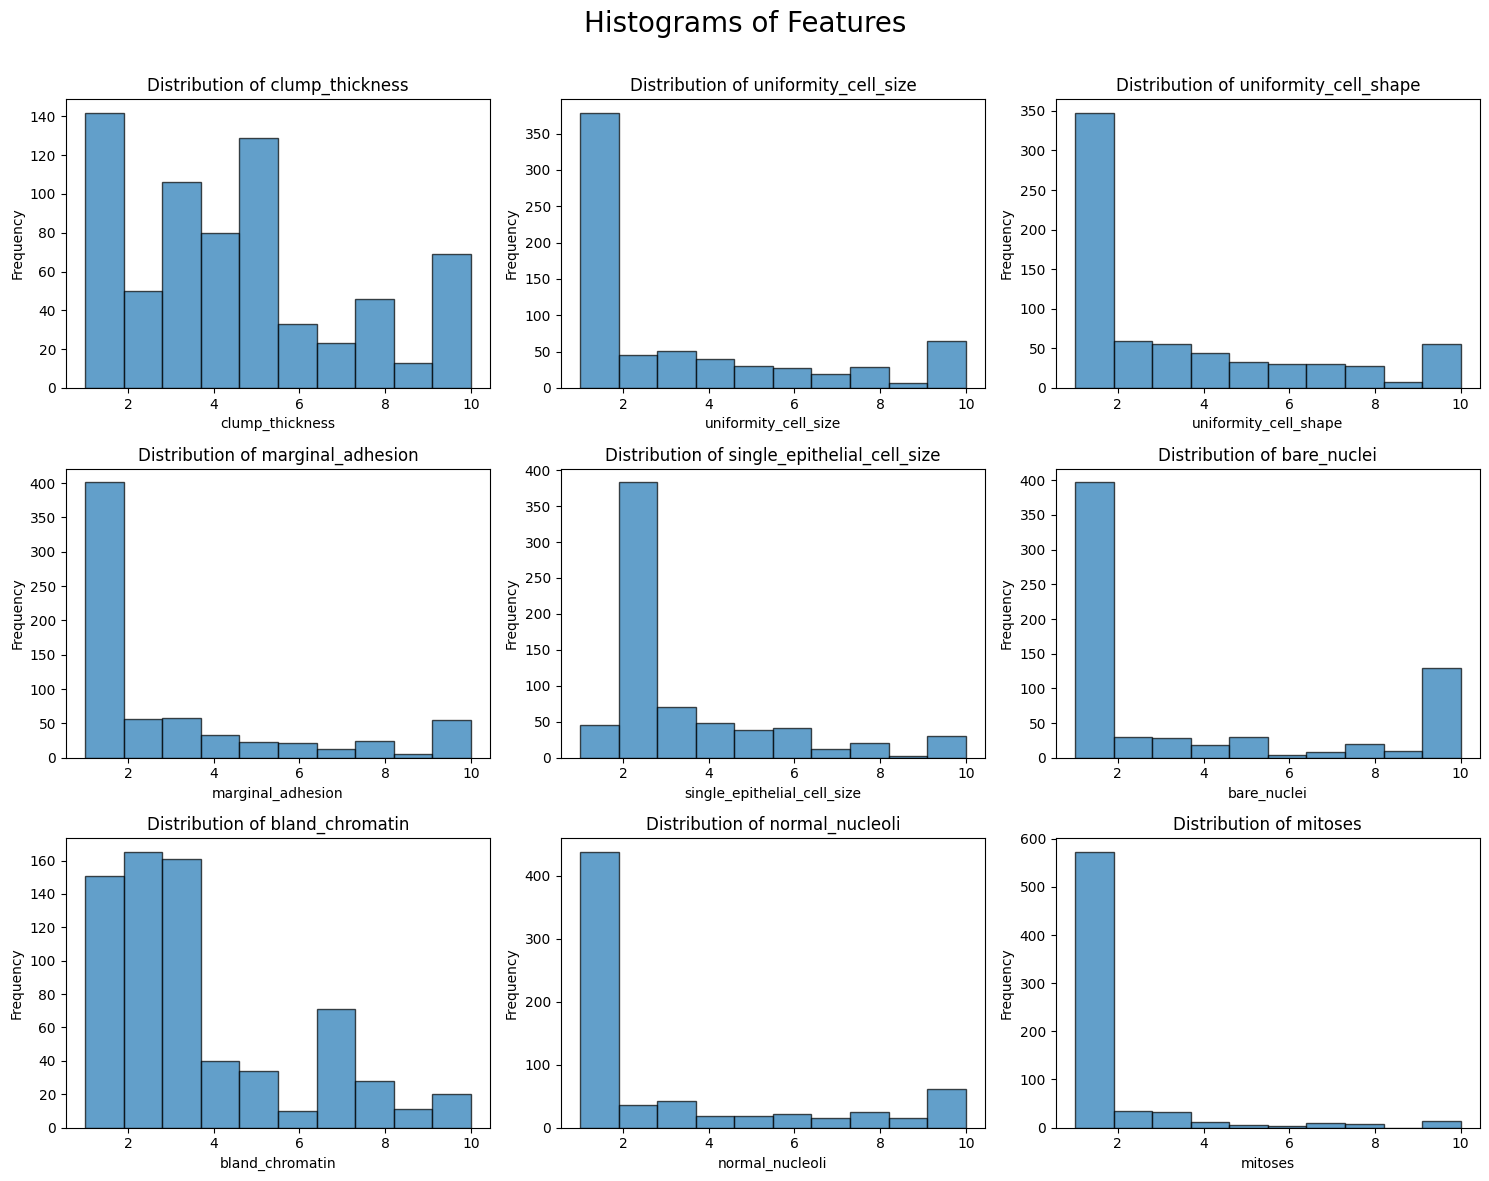

In [ ]:
# Plot distribution of features (histogram)
features = [
    'clump_thickness', 'uniformity_cell_size', 'uniformity_cell_shape',
    'marginal_adhesion', 'single_epithelial_cell_size', 'bare_nuclei',
    'bland_chromatin', 'normal_nucleoli', 'mitoses'
]

# Create a figure and a grid layout (3x3)
fig, axes = plt.subplots(3, 3, figsize=(15, 12))

# Flatten the axes array to iterate through it
axes = axes.flatten()

# Loop through the features and plot each in its respective subplot
for i, col in enumerate(features):
    axes[i].hist(df[col], bins=10, edgecolor='k', alpha=0.7)
    axes[i].set_title(f'Distribution of {col}')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Frequency')
plt.suptitle('Histograms of Features\n', fontsize=20)

# Adjust layout for better spacing
plt.tight_layout()

plt.show()

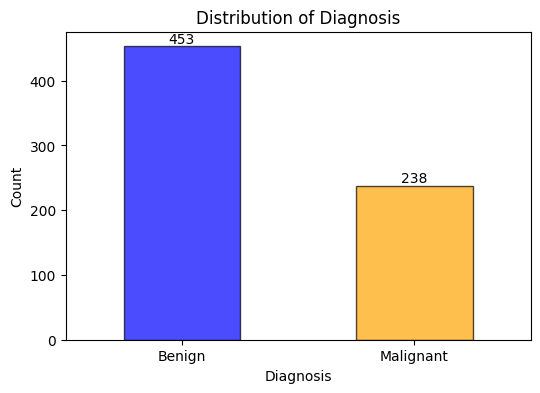

In [ ]:
# Plot distribution of diagnosis (bar chart)
plt.figure(figsize=(6, 4))
df['diagnosis'].value_counts().plot(kind='bar', color=['blue', 'orange'], edgecolor='k', alpha=0.7)
# Add count on top of each bar
for i, count in enumerate(df['diagnosis'].value_counts()):
    plt.text(i, count, str(count), ha='center', va='bottom')
plt.title('Distribution of Diagnosis')
plt.xlabel('Diagnosis')
plt.ylabel('Count')
plt.xticks(ticks=[0, 1], labels=['Benign', 'Malignant'], rotation=0)
plt.show()

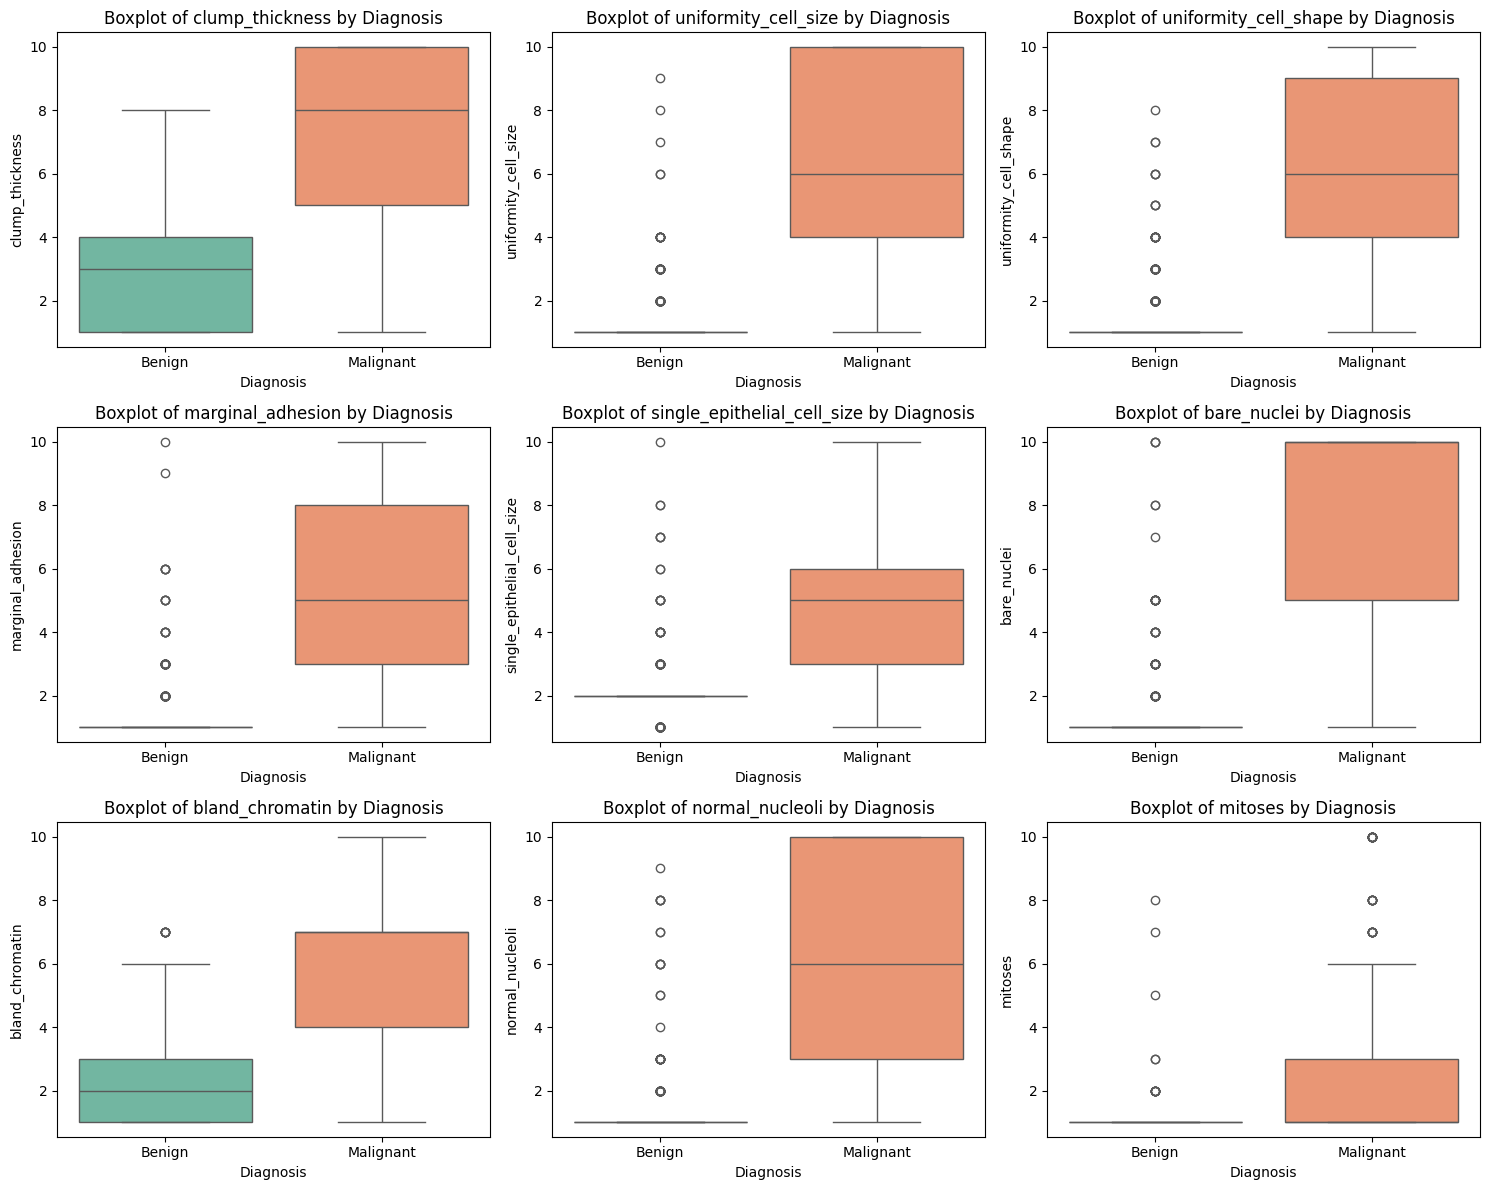

In [ ]:
# Create boxplot for each feature
plt.figure(figsize=(15, 12))

# Loop through the features and plot each boxplot in its respective subplot
for i, feature in enumerate(features, 1):
    plt.subplot(3, 3, i)
    sns.boxplot(data=df, x='diagnosis', y=feature,
                hue='diagnosis', palette="Set2", legend=False)
    plt.title(f'Boxplot of {feature} by Diagnosis')
    plt.xlabel('Diagnosis')
    plt.xticks(ticks=[0, 1], labels=['Benign', 'Malignant'], rotation=0)
    plt.ylabel(feature)

plt.tight_layout()

plt.show()



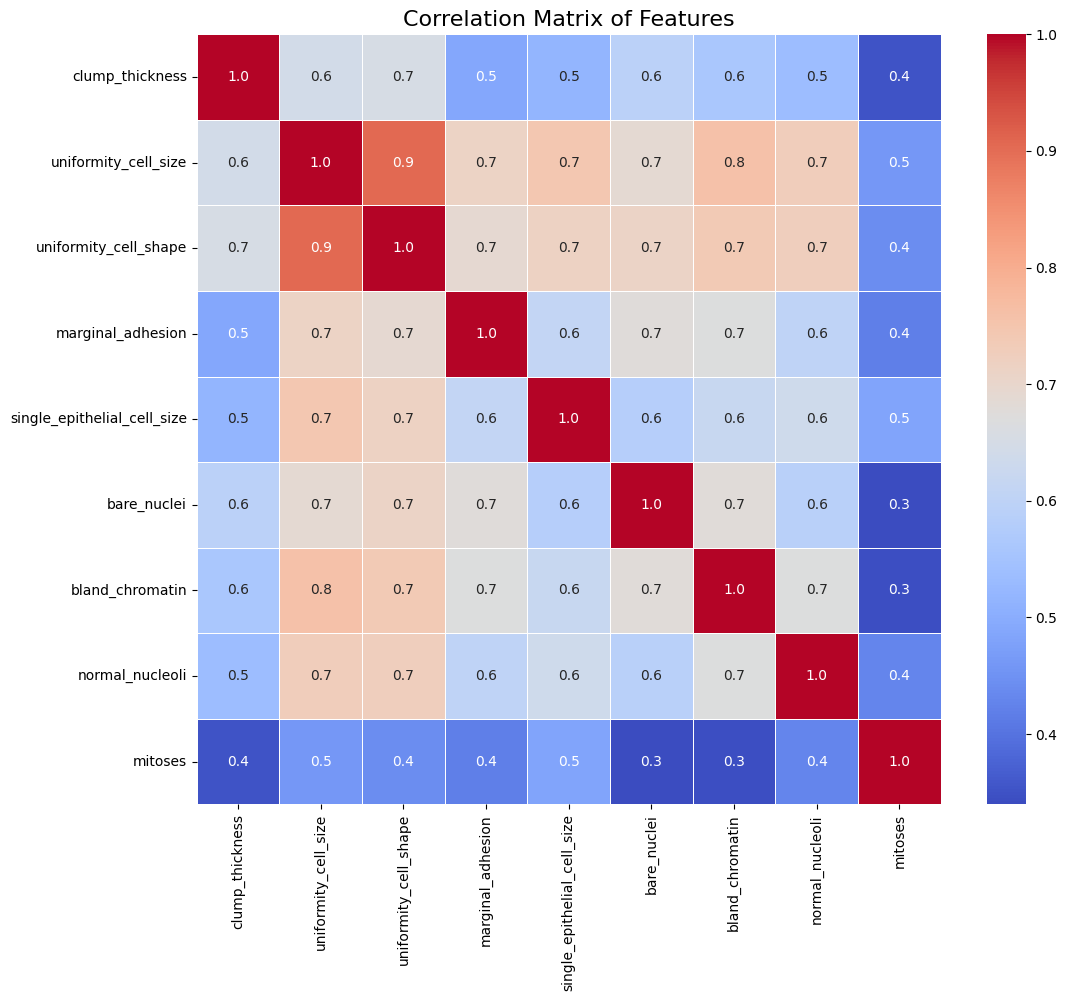

In [ ]:
# Create a correlation matrix for features
correlation_matrix = df.drop(columns=['diagnosis']).corr()

# Visualize the correlation matrix using a heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, fmt='.1f', cmap='coolwarm',linewidths=0.5)
plt.title('Correlation Matrix of Features', fontsize=16)
plt.show()


## **DATA STANDARDIZATION**

In [ ]:
# 1. Standardization for data in target column
# Map the diagnosis values: 2 -> 0 (benign), 4 -> 1 (malignant)
bcw_imputed['diagnosis'] = bcw_imputed['diagnosis'].map({2: 0, 4: 1})

# Verify the mapping
print("Updated unique values in 'diagnosis':", bcw_imputed['diagnosis'].unique())

Updated unique values in 'diagnosis': [0 1]


In [ ]:
# 2. Feature scaling using RobustScaler
# Initialize the scaler
scaler = RobustScaler()

# Apply scaling to the features (exclude ID and diagnosis columns)
X_scaled = scaler.fit_transform(bcw_imputed[features])

# Create a new DataFrame with scaled features and diagnosis
bcw_scaled = pd.DataFrame(X_scaled, columns=features)
bcw_scaled['diagnosis'] = bcw_imputed['diagnosis']

# Display the first few rows of the scaled DataFrame
bcw_scaled.head()

,clump_thickness,uniformity_cell_size,uniformity_cell_shape,marginal_adhesion,single_epithelial_cell_size,bare_nuclei,bland_chromatin,normal_nucleoli,mitoses,diagnosis
0,0.25,0.00,0.00,0.000000,0.0,0.0,0.0,0.000000,0.0,0
1,0.25,0.75,0.75,1.333333,2.5,1.8,0.0,0.333333,0.0,0
2,-0.25,0.00,0.00,0.000000,0.0,0.2,0.0,0.000000,0.0,0
3,0.50,1.75,1.75,0.000000,0.5,0.6,0.0,2.000000,0.0,0
4,0.00,0.00,0.00,0.666667,0.0,0.0,0.0,0.000000,0.0,0


## **CLASS BALANCING**

In [ ]:
# SMOTE (Synthetic Minority Over-sampling Technique)
# Separate features and target variable (diagnosis)
X = bcw_scaled.drop(columns=['diagnosis'])
y = bcw_scaled['diagnosis']

# Apply SMOTE to balance the dataset
smote = SMOTE(random_state=42)

# Fit and apply SMOTE on the dataset
X_resampled, y_resampled = smote.fit_resample(X, y)

# Create a new DataFrame with balanced features and target variable
bcw_balanced = pd.concat([X_resampled, y_resampled], axis=1)

# Display the class distribution before and after oversampling
print("Class distribution before oversampling:\n", y.value_counts())
print("\nClass distribution after oversampling:\n", y_resampled.value_counts())


Class distribution before oversampling:
 diagnosis
0    453
1    238
Name: count, dtype: int64

Class distribution after oversampling:
 diagnosis
0    453
1    453
Name: count, dtype: int64


## **DATA SPLITTING**

In [ ]:
# Perform train-test split (80:20)
X_train, X_test, y_train, y_test = train_test_split(
    bcw_balanced.drop(columns=['diagnosis']),
    bcw_balanced['diagnosis'],
    test_size=0.2, random_state=42)

# Create DataFrames for training and testing sets
train_data = pd.concat([X_train, y_train], axis=1)
test_data = pd.concat([X_test, y_test], axis=1)

# Display the first 20 rows of train data
train_data.head(20)

,clump_thickness,uniformity_cell_size,uniformity_cell_shape,marginal_adhesion,single_epithelial_cell_size,bare_nuclei,bland_chromatin,normal_nucleoli,mitoses,diagnosis
84,-0.250000,1.000000,1.500000,2.333333,3.000000,1.600000,1.333333,3.000000,6.0,1
10,-0.750000,0.000000,0.000000,0.000000,-0.500000,0.000000,0.000000,0.000000,0.0,0
616,-0.750000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.666667,0.000000,0.0,0
250,1.500000,0.750000,0.750000,3.000000,0.000000,1.800000,0.666667,0.666667,2.0,1
478,0.250000,0.000000,0.250000,0.000000,0.000000,0.000000,-0.666667,0.000000,0.0,0
743,1.213854,1.429219,1.572292,0.857431,1.713854,1.543375,1.333333,2.618472,0.0,1
597,0.250000,0.500000,0.250000,2.333333,1.500000,1.800000,1.666667,0.000000,1.0,1
118,-0.750000,0.000000,0.000000,0.000000,1.000000,0.400000,-0.666667,0.000000,0.0,0
806,0.936011,1.994043,1.866064,2.829362,3.255957,1.800000,2.248014,1.829362,2.0,1
321,1.500000,0.000000,0.000000,0.000000,0.000000,1.800000,0.666667,1.000000,0.0,1


## **FEATURE SELECTION**

In [ ]:
# Feature selection using Random forest
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, StratifiedKFold

# Extract features and target variable
X_rf = bcw_balanced.drop(columns=['diagnosis'])
y_rf = bcw_balanced['diagnosis']

# Initialize RandomForest Classifier
rf = RandomForestClassifier(n_estimators=100, random_state=0)

# 5-Fold Cross-Validation using AUC as the scoring metric
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
scores = cross_val_score(rf, X_rf, y_rf, cv=cv, scoring='roc_auc')

# Fit the Random Forest model to get feature importances
rf.fit(X_rf, y_rf)

# Get feature importances
feature_importances = rf.feature_importances_

# Create a DataFrame to display feature importance
feature_importance_df = pd.DataFrame({
    'Feature': X_rf.columns,
    'Importance': feature_importances
})

print("Cross-Validation AUC Scores:", scores)
print("Average AUC Score:", np.mean(scores))
print("\nFeature Importances:\n", feature_importance_df)

Cross-Validation AUC Scores: [0.98719961 0.99194139 0.99554335 0.99517705 0.98687424]
Average AUC Score: 0.9913471266218519

Feature Importances:
                        Feature  Importance
0              clump_thickness    0.042907
1         uniformity_cell_size    0.334629
2        uniformity_cell_shape    0.222504
3            marginal_adhesion    0.022675
4  single_epithelial_cell_size    0.093189
5                  bare_nuclei    0.112468
6              bland_chromatin    0.132159
7              normal_nucleoli    0.034090
8                      mitoses    0.005379


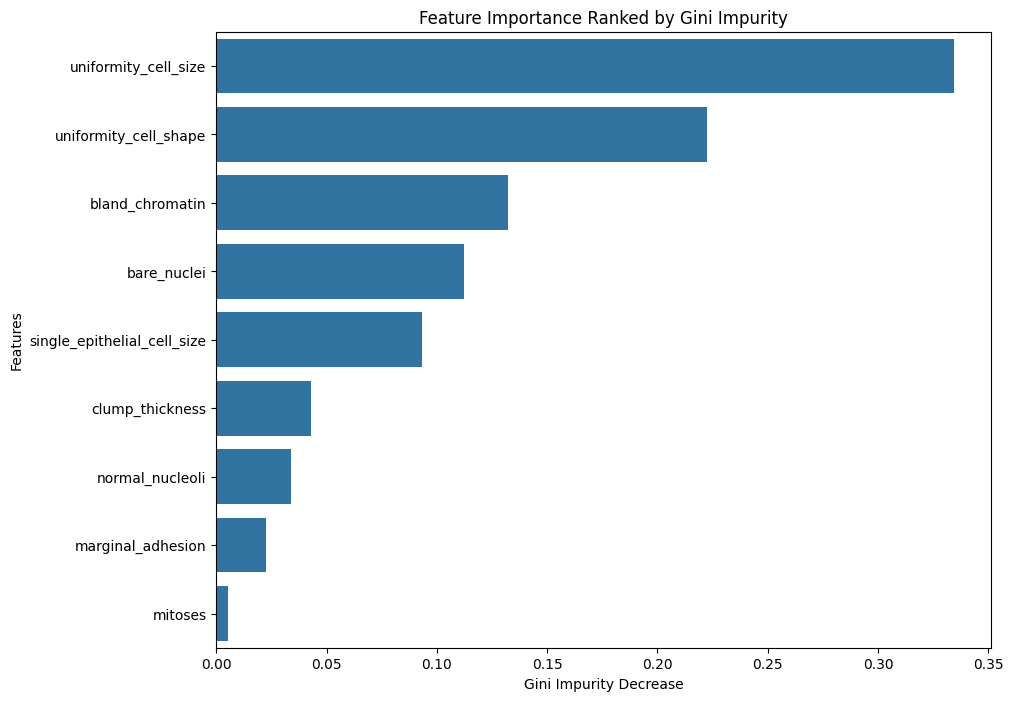

In [ ]:
# Sort the DataFrame by importance in ascending order for the plot
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Plotting
plt.figure(figsize=(10, 8))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df)

plt.title('Feature Importance Ranked by Gini Impurity')
plt.xlabel('Gini Impurity Decrease')
plt.ylabel('Features')

plt.show()

## **LOGISTIC REGRESSION**


Training Logistic Regression with All Features...
Fitting 5 folds for each of 8 candidates, totalling 40 fits

Best Parameters for All Features: {'C': 1, 'penalty': 'l2', 'solver': 'liblinear'} with AUC = 0.9950 

Classification Report for testing LR with All Features:

              precision    recall  f1-score   support

           0     0.9474    0.9677    0.9574        93
           1     0.9655    0.9438    0.9545        89

    accuracy                         0.9560       182
   macro avg     0.9564    0.9558    0.9560       182
weighted avg     0.9562    0.9560    0.9560       182

AUC Score for LR with All Features: 0.9931


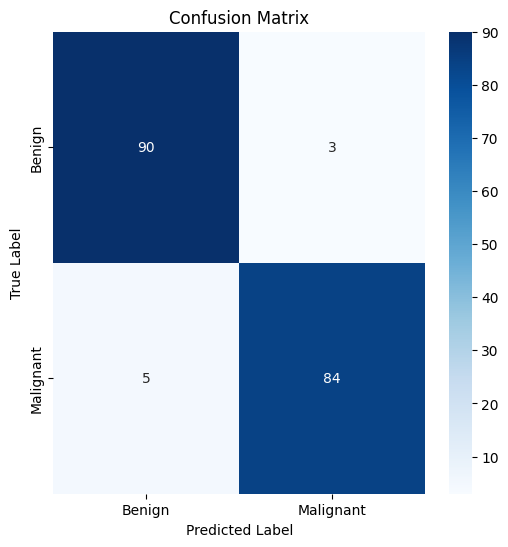

Sensitivity for All Features: 0.9438
Specificity for All Features: 0.9677
Positive Predictive Value (PPV) for All Features: 0.9655
Negative Predictive Value (NPV) for All Features: 0.9474

Training Logistic Regression with Top 8 Features...
Fitting 5 folds for each of 8 candidates, totalling 40 fits

Best Parameters for Top 8 Features: {'C': 1, 'penalty': 'l1', 'solver': 'liblinear'} with AUC = 0.9947 

Classification Report for testing LR with Top 8 Features:

              precision    recall  f1-score   support

           0     0.9574    0.9677    0.9626        93
           1     0.9659    0.9551    0.9605        89

    accuracy                         0.9615       182
   macro avg     0.9617    0.9614    0.9615       182
weighted avg     0.9616    0.9615    0.9615       182

AUC Score for LR with Top 8 Features: 0.9920


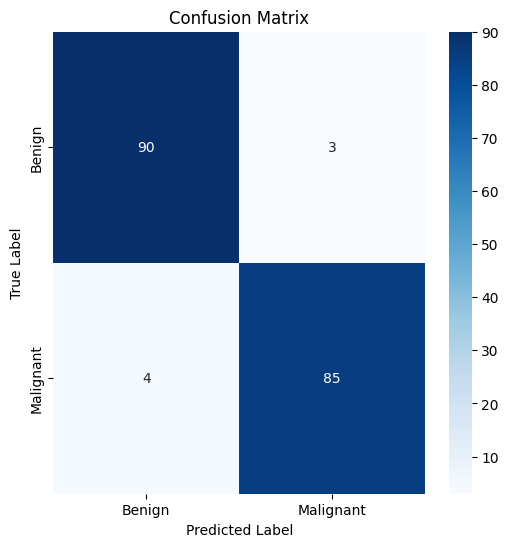

Sensitivity for Top 8 Features: 0.9551
Specificity for Top 8 Features: 0.9677
Positive Predictive Value (PPV) for Top 8 Features: 0.9659
Negative Predictive Value (NPV) for Top 8 Features: 0.9574

Training Logistic Regression with Top 7 Features...
Fitting 5 folds for each of 8 candidates, totalling 40 fits

Best Parameters for Top 7 Features: {'C': 10, 'penalty': 'l2', 'solver': 'liblinear'} with AUC = 0.9951 

Classification Report for testing LR with Top 7 Features:

              precision    recall  f1-score   support

           0     0.9574    0.9677    0.9626        93
           1     0.9659    0.9551    0.9605        89

    accuracy                         0.9615       182
   macro avg     0.9617    0.9614    0.9615       182
weighted avg     0.9616    0.9615    0.9615       182

AUC Score for LR with Top 7 Features: 0.9920


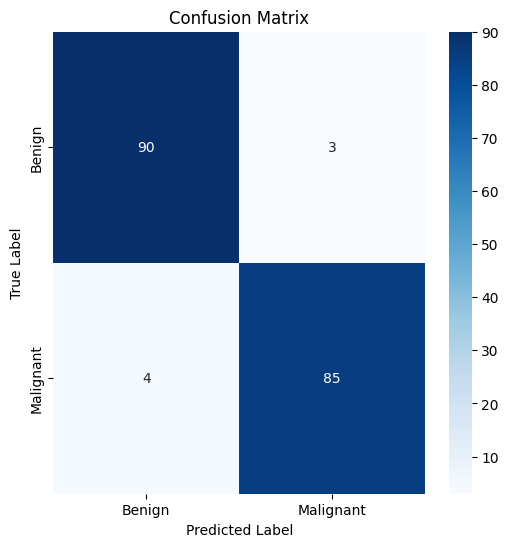

Sensitivity for Top 7 Features: 0.9551
Specificity for Top 7 Features: 0.9677
Positive Predictive Value (PPV) for Top 7 Features: 0.9659
Negative Predictive Value (NPV) for Top 7 Features: 0.9574


In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix

# Define features based on importance
all_features = X_train.columns.tolist()
top_8_features = ['uniformity_cell_size', 'uniformity_cell_shape',
                  'single_epithelial_cell_size', 'bare_nuclei',
                  'bland_chromatin', 'clump_thickness', 'normal_nucleoli',
                  'marginal_adhesion']
top_7_features = ['uniformity_cell_size', 'uniformity_cell_shape',
                  'single_epithelial_cell_size', 'bare_nuclei',
                  'bland_chromatin', 'clump_thickness', 'normal_nucleoli']

# Hyperparameter grid for Logistic Regression
param_grid = {
    'C': [0.01, 0.1, 1, 10],
    'penalty': ['l1', 'l2'],  # L1 = Lasso, L2 = Ridge
    'solver': ['liblinear']  # Supports both l1 and l2
}

# Function to train, tune, and evaluate a model
def train_and_evaluate(features, feature_set_name):
    print(f"\nTraining Logistic Regression with {feature_set_name}...")
    X_train_subset = X_train[features]
    X_test_subset = X_test[features]

    # Initialize logistic regression and perform GridSearchCV
    logreg = LogisticRegression(random_state=42, max_iter=1000)
    grid_search = GridSearchCV(
        logreg,
        param_grid,
        cv=5,  # Perform 5-fold cross-validation on training data
        scoring='roc_auc',
        n_jobs=-1,
        verbose=1
    )
    grid_search.fit(X_train_subset, y_train)

    # Best hyperparameters
    best_params = grid_search.best_params_
    best_score = grid_search.best_score_
    print(f"\nBest Parameters for {feature_set_name}: {best_params} with AUC = {best_score:.4f} ")

    # Retrain the model on the entire training set using the best parameters
    optimized_LR = LogisticRegression(
        random_state=42,
        max_iter=1000,
        **best_params
    )
    optimized_LR.fit(X_train_subset, y_train)

    # Evaluate the final model on the test set
    y_pred = optimized_LR.predict(X_test_subset)
    y_pred_proba = optimized_LR.predict_proba(X_test_subset)[:, 1]

    print(f"\nClassification Report for testing LR with {feature_set_name}:\n")
    print(classification_report(y_test, y_pred, digits=4))
    auc_score = roc_auc_score(y_test, y_pred_proba)
    print(f"AUC Score for LR with {feature_set_name}: {auc_score:.4f}")

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    tn, fp, fn, tp = cm.ravel()  # Extract true negatives, false positives, false negatives, true positives

    # Visualization of Confusion Matrix
    plt.figure(figsize=(6, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Benign', 'Malignant'],
                yticklabels=['Benign', 'Malignant'])
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

    # Sensitivity
    sensitivity = tp / (tp + fn)
    # Specificity
    specificity = tn / (tn + fp)
    # Positive Predictive Value (PPV)
    ppv = tp / (tp + fp)
    # Negative Predictive Value (NPV)
    npv = tn / (tn + fn)

    print(f"Sensitivity for {feature_set_name}: {sensitivity:.4f}")
    print(f"Specificity for {feature_set_name}: {specificity:.4f}")
    print(f"Positive Predictive Value (PPV) for {feature_set_name}: {ppv:.4f}")
    print(f"Negative Predictive Value (NPV) for {feature_set_name}: {npv:.4f}")

    return best_params, auc_score, sensitivity, specificity, ppv, npv

# Train and evaluate models
results_LR = {}
results_LR['All Features'] = train_and_evaluate(all_features, "All Features")
results_LR['Top 8 Features'] = train_and_evaluate(top_8_features, "Top 8 Features")
results_LR['Top 7 Features'] = train_and_evaluate(top_7_features, "Top 7 Features")

## **SUPPORT VECTOR MACHINE**


Training SVM with All Features...
Fitting 5 folds for each of 35 candidates, totalling 175 fits

Best Parameters for All Features: {'C': 1, 'kernel': 'linear'} with AUC = 0.9948

Classification Report for testing SVM with All Features:

              precision    recall  f1-score   support

           0     0.9674    0.9570    0.9622        93
           1     0.9556    0.9663    0.9609        89

    accuracy                         0.9615       182
   macro avg     0.9615    0.9616    0.9615       182
weighted avg     0.9616    0.9615    0.9615       182

AUC Score for SVM with All Features: 0.9934


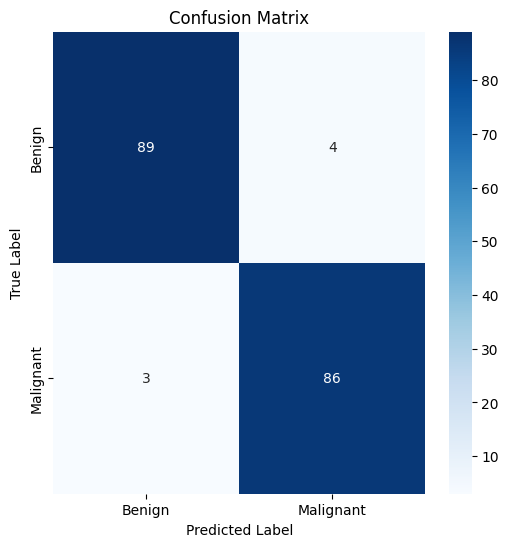

Sensitivity for All Features: 0.9663
Specificity for All Features: 0.9570
Positive Predictive Value (PPV) for All Features: 0.9556
Negative Predictive Value (NPV) for All Features: 0.9674

Training SVM with Top 8 Features...
Fitting 5 folds for each of 35 candidates, totalling 175 fits

Best Parameters for Top 8 Features: {'C': 1, 'kernel': 'linear'} with AUC = 0.9948

Classification Report for testing SVM with Top 8 Features:

              precision    recall  f1-score   support

           0     0.9677    0.9677    0.9677        93
           1     0.9663    0.9663    0.9663        89

    accuracy                         0.9670       182
   macro avg     0.9670    0.9670    0.9670       182
weighted avg     0.9670    0.9670    0.9670       182

AUC Score for SVM with Top 8 Features: 0.9928


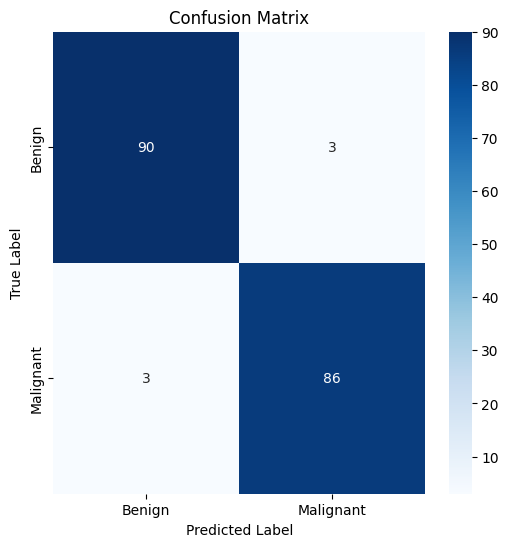

Sensitivity for Top 8 Features: 0.9663
Specificity for Top 8 Features: 0.9677
Positive Predictive Value (PPV) for Top 8 Features: 0.9663
Negative Predictive Value (NPV) for Top 8 Features: 0.9677

Training SVM with Top 7 Features...
Fitting 5 folds for each of 35 candidates, totalling 175 fits

Best Parameters for Top 7 Features: {'C': 10, 'kernel': 'linear'} with AUC = 0.9956

Classification Report for testing SVM with Top 7 Features:

              precision    recall  f1-score   support

           0     0.9674    0.9570    0.9622        93
           1     0.9556    0.9663    0.9609        89

    accuracy                         0.9615       182
   macro avg     0.9615    0.9616    0.9615       182
weighted avg     0.9616    0.9615    0.9615       182

AUC Score for SVM with Top 7 Features: 0.9921


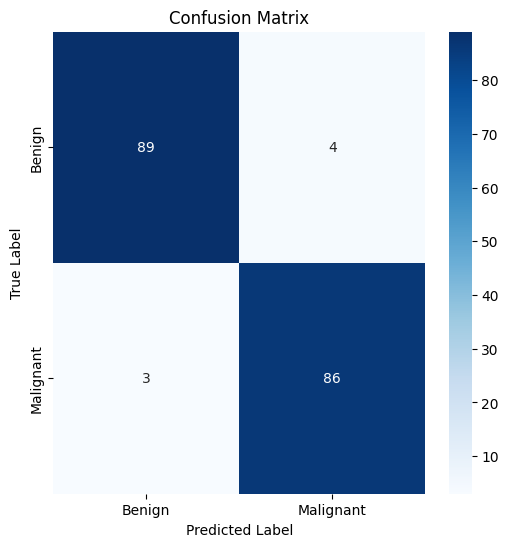

Sensitivity for Top 7 Features: 0.9663
Specificity for Top 7 Features: 0.9570
Positive Predictive Value (PPV) for Top 7 Features: 0.9556
Negative Predictive Value (NPV) for Top 7 Features: 0.9674


In [ ]:
from sklearn.svm import SVC

# Hyperparameter grid for SVM
svm_param_grid = [
    {'C': [ 0.01, 0.1, 1, 10, 100], 'kernel': ['linear']},
    {'C': [ 0.01, 0.1, 1, 10, 100], 'kernel': ['rbf', 'poly', 'sigmoid'], 'gamma': ['scale', 'auto']}  # gamma included for non-linear kernels
]

# Function to train, tune, and evaluate an SVM model
def train_and_evaluate_svm(features, feature_set_name):
    print(f"\nTraining SVM with {feature_set_name}...")
    X_train_subset = X_train[features]
    X_test_subset = X_test[features]

    # Initialize SVM and perform GridSearchCV
    svm = SVC(probability=True, random_state=42)
    grid_search = GridSearchCV(
        svm,
        svm_param_grid,
        cv=5,  # Perform 5-fold cross-validation on training data
        scoring='roc_auc',
        n_jobs=-1,
        verbose=1
    )
    grid_search.fit(X_train_subset, y_train)

    # Best hyperparameters
    best_params = grid_search.best_params_
    best_score = grid_search.best_score_
    print(f"\nBest Parameters for {feature_set_name}: {best_params} with AUC = {best_score:.4f}")

    # Retrain the model on the entire training set using the best parameters
    optimized_svm = SVC(
       probability=True,
       random_state=42,
       **best_params
    )
    optimized_svm.fit(X_train_subset, y_train)

    # Evaluate the final model on the test set
    y_pred = optimized_svm.predict(X_test_subset)
    y_pred_proba = optimized_svm.predict_proba(X_test_subset)[:, 1]

    print(f"\nClassification Report for testing SVM with {feature_set_name}:\n")
    print(classification_report(y_test, y_pred, digits=4))
    auc_score = roc_auc_score(y_test, y_pred_proba)
    print(f"AUC Score for SVM with {feature_set_name}: {auc_score:.4f}")

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    tn, fp, fn, tp = cm.ravel()

    # Visualization of Confusion Matrix
    plt.figure(figsize=(6, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Benign', 'Malignant'],
                yticklabels=['Benign', 'Malignant'])
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

    # Sensitivity
    sensitivity = tp / (tp + fn)
    # Specificity
    specificity = tn / (tn + fp)
    # Positive Predictive Value (PPV)
    ppv = tp / (tp + fp)
    # Negative Predictive Value (NPV)
    npv = tn / (tn + fn)

    print(f"Sensitivity for {feature_set_name}: {sensitivity:.4f}")
    print(f"Specificity for {feature_set_name}: {specificity:.4f}")
    print(f"Positive Predictive Value (PPV) for {feature_set_name}: {ppv:.4f}")
    print(f"Negative Predictive Value (NPV) for {feature_set_name}: {npv:.4f}")

    return best_params, auc_score, sensitivity, specificity, ppv, npv

# Train and evaluate models
results_SVM = {}
results_SVM['All Features'] = train_and_evaluate_svm(all_features, "All Features")
results_SVM['Top 8 Features'] = train_and_evaluate_svm(top_8_features, "Top 8 Features")
results_SVM['Top 7 Features'] = train_and_evaluate_svm(top_7_features, "Top 7 Features")

DECISION TREE MACHINE


Training Decision Tree with All Features...
Fitting 5 folds for each of 120 candidates, totalling 600 fits

Best Parameters for All Features: {'criterion': 'gini', 'max_depth': None, 'min_samples_leaf': 10, 'min_samples_split': 2} with AUC = 0.9860

Classification Report for testing DT with All Features:

              precision    recall  f1-score   support

           0     0.9462    0.9462    0.9462        93
           1     0.9438    0.9438    0.9438        89

    accuracy                         0.9451       182
   macro avg     0.9450    0.9450    0.9450       182
weighted avg     0.9451    0.9451    0.9451       182

AUC Score for DT with All Features: 0.9784


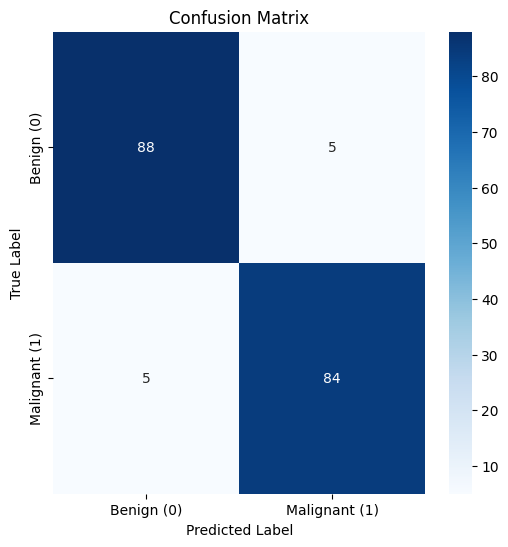

Sensitivity for All Features: 0.9438
Specificity for All Features: 0.9462
Positive Predictive Value (PPV) for All Features: 0.9438
Negative Predictive Value (NPV) for All Features: 0.9462

Training Decision Tree with Top 8 Features...
Fitting 5 folds for each of 120 candidates, totalling 600 fits

Best Parameters for Top 8 Features: {'criterion': 'gini', 'max_depth': None, 'min_samples_leaf': 10, 'min_samples_split': 2} with AUC = 0.9860

Classification Report for testing DT with Top 8 Features:

              precision    recall  f1-score   support

           0     0.9462    0.9462    0.9462        93
           1     0.9438    0.9438    0.9438        89

    accuracy                         0.9451       182
   macro avg     0.9450    0.9450    0.9450       182
weighted avg     0.9451    0.9451    0.9451       182

AUC Score for DT with Top 8 Features: 0.9799


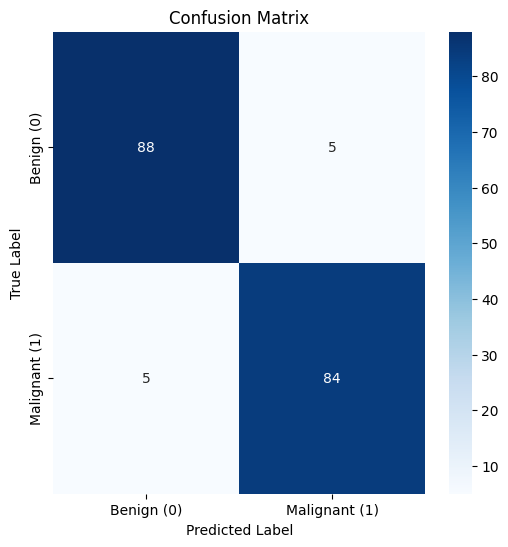

Sensitivity for Top 8 Features: 0.9438
Specificity for Top 8 Features: 0.9462
Positive Predictive Value (PPV) for Top 8 Features: 0.9438
Negative Predictive Value (NPV) for Top 8 Features: 0.9462

Training Decision Tree with Top 7 Features...
Fitting 5 folds for each of 120 candidates, totalling 600 fits

Best Parameters for Top 7 Features: {'criterion': 'entropy', 'max_depth': None, 'min_samples_leaf': 10, 'min_samples_split': 2} with AUC = 0.9893

Classification Report for testing DT with Top 7 Features:

              precision    recall  f1-score   support

           0     0.9663    0.9247    0.9451        93
           1     0.9247    0.9663    0.9451        89

    accuracy                         0.9451       182
   macro avg     0.9455    0.9455    0.9451       182
weighted avg     0.9460    0.9451    0.9451       182

AUC Score for DT with Top 7 Features: 0.9799


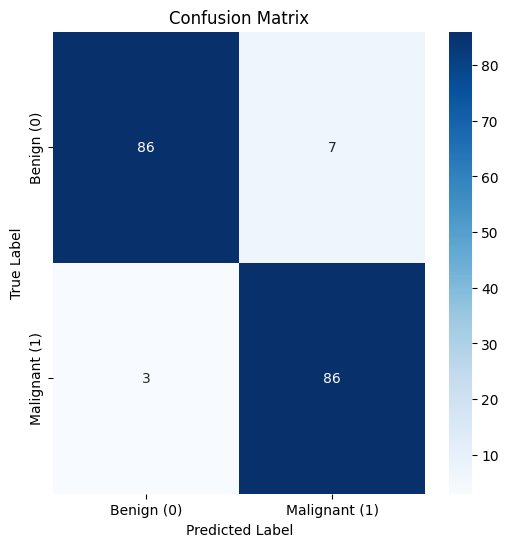

Sensitivity for Top 7 Features: 0.9663
Specificity for Top 7 Features: 0.9247
Positive Predictive Value (PPV) for Top 7 Features: 0.9247
Negative Predictive Value (NPV) for Top 7 Features: 0.9663


In [ ]:
from sklearn.tree import DecisionTreeClassifier, plot_tree

#Hyperparameter grid for logistic regression
param_grid_dt = {
    'criterion': ['gini', 'entropy'],   # Splitting criterion
    'max_depth': [None, 3, 5, 7, 10],   # Maximum depth of the tree
    'min_samples_split': [2, 5, 10],    # Min. number of samples required to split
    'min_samples_leaf': [1, 3, 5, 10]   # Min. number of samples in a leaf node
}

def train_and_evaluate_dt(features, feature_set_name):
    """
    Trains a Decision Tree using GridSearchCV for hyperparameter tuning,
    then evaluates it on the test set using accuracy, AUC, sensitivity,
    specificity, PPV, and NPV.
    """
    print(f"\nTraining Decision Tree with {feature_set_name}...")
    X_train_subset = X_train[features]
    X_test_subset = X_test[features]

    # 1. Initialize Decision Tree and set up GridSearchCV
    dt = DecisionTreeClassifier(random_state=42)
    grid_search = GridSearchCV(
        dt,
        param_grid_dt,
        cv=5,             # 5-fold cross-validation
        scoring='roc_auc',
        n_jobs=-1,        # Utilize all available CPU cores
        verbose=1         # Print progress messages
    )
    grid_search.fit(X_train_subset, y_train)

    # 3. Retrieve best hyperparameters and cross-validation AUC
    best_params = grid_search.best_params_
    best_score = grid_search.best_score_
    print(f"\nBest Parameters for {feature_set_name}: {best_params} with AUC = {best_score:.4f}")

    # 4. Retrain a Decision Tree using the best found hyperparameters
    optimized_DT = DecisionTreeClassifier(
        random_state=42,
        **best_params
    )
    optimized_DT.fit(X_train_subset, y_train)

    # 5. Evaluate the final model on the test subset
    y_pred = optimized_DT.predict(X_test_subset)
    y_pred_proba = optimized_DT.predict_proba(X_test_subset)[:, 1]

    print(f"\nClassification Report for testing DT with {feature_set_name}:\n")
    print(classification_report(y_test, y_pred, digits=4))

    # 6. Calculate AUC on the test set
    auc_score = roc_auc_score(y_test, y_pred_proba)
    print(f"AUC Score for DT with {feature_set_name}: {auc_score:.4f}")

    # 7. Confusion Matrix and derived metrics
    cm = confusion_matrix(y_test, y_pred)
    tn, fp, fn, tp = cm.ravel()

    # Plot Confusion Matrix
    plt.figure(figsize=(6, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Benign (0)', 'Malignant (1)'],
                yticklabels=['Benign (0)', 'Malignant (1)'])
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

    #Sensitivity (Recall for positive class)
    sensitivity = tp / (tp + fn)
   # Specificity
    specificity = tn / (tn + fp)
   # Positive Predictive Value (PPV)
    ppv = tp / (tp + fp)
   # Negative Predictive Value (NPV)
    npv = tn / (tn + fn)

    print(f"Sensitivity for {feature_set_name}: {sensitivity:.4f}")
    print(f"Specificity for {feature_set_name}: {specificity:.4f}")
    print(f"Positive Predictive Value (PPV) for {feature_set_name}: {ppv:.4f}")
    print(f"Negative Predictive Value (NPV) for {feature_set_name}: {npv:.4f}")

    return best_params, auc_score, sensitivity, specificity, ppv, npv

results_DT = {}
results_DT['All Features'] = train_and_evaluate_dt(all_features, "All Features")
results_DT['Top 8 Features'] = train_and_evaluate_dt(top_8_features, "Top 8 Features")
results_DT['Top 7 Features'] = train_and_evaluate_dt(top_7_features, "Top 7 Features")

# **K NEAREST NEIGHBOUR**



The optimal number of neighbors is  1 


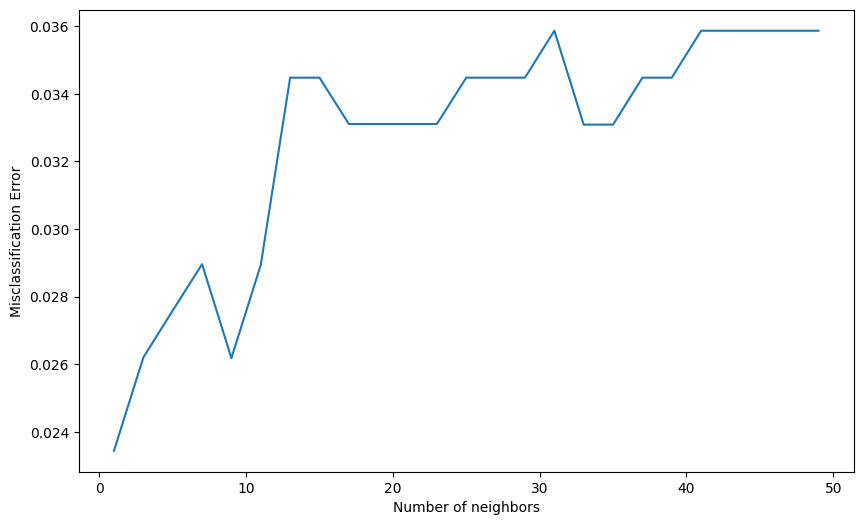

In [ ]:
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix
from sklearn.neighbors import KNeighborsClassifier

# Define features based on importance
all_features = X_train.columns.tolist()
top_8_features = ['uniformity_cell_size', 'uniformity_cell_shape',
                  'single_epithelial_cell_size', 'bare_nuclei',
                  'bland_chromatin', 'clump_thickness', 'normal_nucleoli',
                  'marginal_adhesion']
top_7_features = ['uniformity_cell_size', 'uniformity_cell_shape',
                  'single_epithelial_cell_size', 'bare_nuclei',
                  'bland_chromatin', 'clump_thickness', 'normal_nucleoli']

# Fit training data to KNN with neighors of 5
knn = KNeighborsClassifier(n_neighbors = 5)
knn.fit(X_train, y_train)

# Obtain score for training dataset
knn.score(X_test, y_test)

# Preparations for getting optimal k value
neighbors = []
cv_scores = []

from sklearn.model_selection import cross_val_score

# Perform 10-fold cross validation of different k values
for k in range(1, 51, 2):
	neighbors.append(k)
	knn = KNeighborsClassifier(n_neighbors = k)
	scores = cross_val_score(
		knn, X_train, y_train, cv = 10, scoring = 'accuracy')
	cv_scores.append(scores.mean())

MSE = [1-x for x in cv_scores]
optimal_k = neighbors[MSE.index(min(MSE))]
print('The optimal number of neighbors is % d ' % optimal_k)

# Plotting graph to visualize misclassification error versus k
plt.figure(figsize = (10, 6))
plt.plot(neighbors, MSE)
plt.xlabel('Number of neighbors')
plt.ylabel('Misclassification Error')
plt.show()

In [ ]:
def train_and_evaluate(features, feature_set_name):
    print(f"\nTraining KNN with {feature_set_name}...")
    X_train_subset = X_train[features]
    X_test_subset = X_test[features]

    # Initialize KNN using optimized k
    optimized_KNN = KNeighborsClassifier(n_neighbors = optimal_k)
    optimized_KNN.fit(X_train_subset, y_train)

    # Evaluate the final model on the test set
    y_pred = optimized_KNN.predict(X_test_subset)
    y_pred_proba = optimized_KNN.predict_proba(X_test_subset)[:, 1]

    print(f"\nClassification Report for testing KNN with {feature_set_name}:\n")
    print(classification_report(y_test, y_pred, digits=4))
    auc_score = roc_auc_score(y_test, y_pred_proba)
    print(f"AUC Score for LR with {feature_set_name}: {auc_score:.4f}")

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    tn, fp, fn, tp = cm.ravel()  # Extract true negatives, false positives, false negatives, true positives

    # Visualization of Confusion Matrix
    plt.figure(figsize=(6, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Benign', 'Malignant'],
                yticklabels=['Benign', 'Malignant'])
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

    # Sensitivity
    sensitivity = tp / (tp + fn)
    # Specificity
    specificity = tn / (tn + fp)
    # Positive Predictive Value (PPV)
    ppv = tp / (tp + fp)
    # Negative Predictive Value (NPV)
    npv = tn / (tn + fn)

    print(f"Sensitivity for {feature_set_name}: {sensitivity:.4f}")
    print(f"Specificity for {feature_set_name}: {specificity:.4f}")
    print(f"Positive Predictive Value (PPV) for {feature_set_name}: {ppv:.4f}")
    print(f"Negative Predictive Value (NPV) for {feature_set_name}: {npv:.4f}")


    return auc_score, sensitivity, specificity, ppv, npv


Training KNN with All Features...

Classification Report for testing KNN with All Features:

              precision    recall  f1-score   support

           0     0.9889    0.9570    0.9727        93
           1     0.9565    0.9888    0.9724        89

    accuracy                         0.9725       182
   macro avg     0.9727    0.9729    0.9725       182
weighted avg     0.9731    0.9725    0.9725       182

AUC Score for LR with All Features: 0.9729


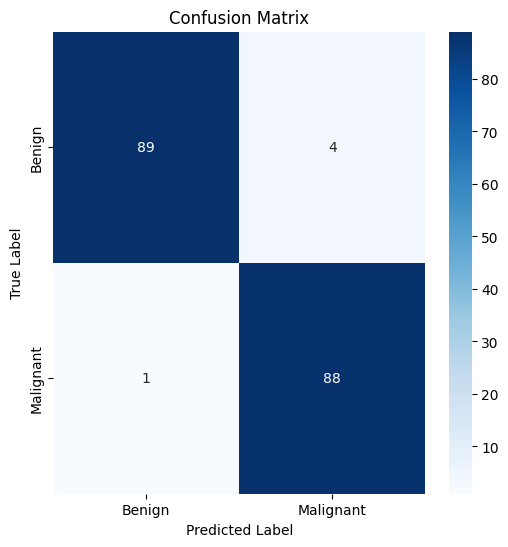

Sensitivity for All Features: 0.9888
Specificity for All Features: 0.9570
Positive Predictive Value (PPV) for All Features: 0.9565
Negative Predictive Value (NPV) for All Features: 0.9889

Training KNN with Top 8 Features...

Classification Report for testing KNN with Top 8 Features:

              precision    recall  f1-score   support

           0     0.9890    0.9677    0.9783        93
           1     0.9670    0.9888    0.9778        89

    accuracy                         0.9780       182
   macro avg     0.9780    0.9783    0.9780       182
weighted avg     0.9783    0.9780    0.9780       182

AUC Score for LR with Top 8 Features: 0.9783


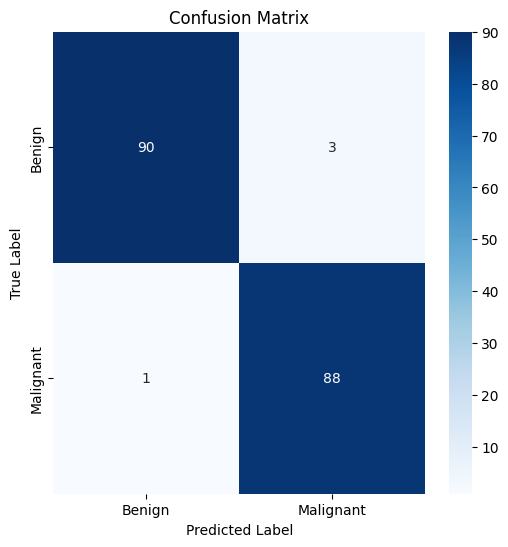

Sensitivity for Top 8 Features: 0.9888
Specificity for Top 8 Features: 0.9677
Positive Predictive Value (PPV) for Top 8 Features: 0.9670
Negative Predictive Value (NPV) for Top 8 Features: 0.9890

Training KNN with Top 7 Features...

Classification Report for testing KNN with Top 7 Features:

              precision    recall  f1-score   support

           0     0.9785    0.9785    0.9785        93
           1     0.9775    0.9775    0.9775        89

    accuracy                         0.9780       182
   macro avg     0.9780    0.9780    0.9780       182
weighted avg     0.9780    0.9780    0.9780       182

AUC Score for LR with Top 7 Features: 0.9780


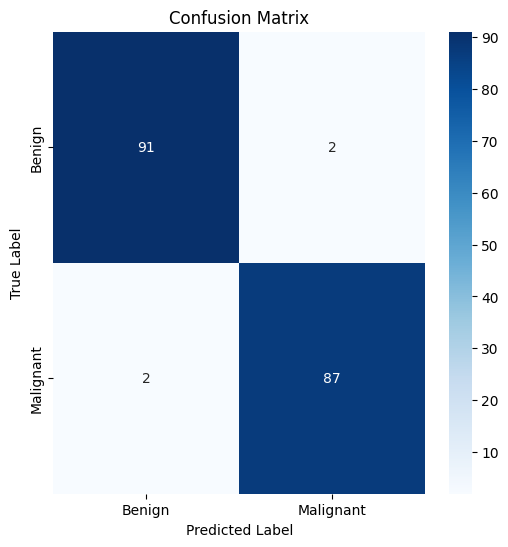

Sensitivity for Top 7 Features: 0.9775
Specificity for Top 7 Features: 0.9785
Positive Predictive Value (PPV) for Top 7 Features: 0.9775
Negative Predictive Value (NPV) for Top 7 Features: 0.9785


In [ ]:
results_KNN = {}
results_KNN['All Features'] = train_and_evaluate(all_features, "All Features")
results_KNN['Top 8 Features'] = train_and_evaluate(top_8_features, "Top 8 Features")
results_KNN['Top 7 Features'] = train_and_evaluate(top_7_features, "Top 7 Features")